In [18]:
import matplotlib.pyplot as plt

import matplotlib.font_manager as font_manager

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['figure.figsize'] = [12, 8]

csfont = {'fontname':'cmss10'}
font = font_manager.FontProperties(family='Latin Modern Roman',
                                   style='normal', size = 8)


In [2]:
import symlens

In [3]:
import symlens as s
from pixell import enmap, utils as putils, powspec
from scipy.interpolate import interp1d
import numpy as np

In [9]:
from orphics import lensing,io,cosmology,maps

shape,wcs = enmap.geometry(shape=(512,512),res=2.0*putils.arcmin,pos=(0,0))
modlmap = enmap.modlmap(shape,wcs)
theory = cosmology.default_theory()
ells = np.arange(0,3000,1)
ctt = theory.lCl('TT',ells)
# ps,_ = powspec.read_camb_scalar("tests/Aug6_highAcc_CDM_scalCls.dat")
# ells = range(ps.shape[-1])

noisemaps = 25.
noisefilter = 15.
beam = 1.4

n2dfilter = (noisefilter*np.pi/180./60.)**2./s.gauss_beam(modlmap,beam)**2.
n2dmaps = (noisemaps*np.pi/180./60.)**2./s.gauss_beam(modlmap,beam)**2.

cltt = theory.lCl('TT',modlmap)
clee = theory.lCl('EE',modlmap)
clbb = theory.lCl('BB',modlmap)
clte = theory.lCl('TE',modlmap)


feed_dict = {}
feed_dict['uC_T_T'] = cltt
feed_dict['tC_Y_T_Y_T'] = cltt+n2dfilter
feed_dict['tC_Y_E_Y_E'] = clee+2*n2dfilter
feed_dict['tC_Y_B_Y_B'] = clbb+2*n2dfilter
feed_dict['tC_Y_T_Y_E'] = clte

feed_dict['uC_T_T'] = cltt
feed_dict['tC_T_T'] = (cltt+n2dmaps)
feed_dict['uC_E_E'] = clee
feed_dict['tC_E_E'] = (clee+n2dmaps*2.)
feed_dict['uC_B_B'] = clbb
feed_dict['tC_B_B'] = (clbb+n2dmaps*2.)
feed_dict['uC_T_E'] = clte
feed_dict['tC_T_E'] = clte




In [10]:
pols = ['TT','EE','TE','EB','TB']

In [11]:
kellmin = 40
kellmax = 3000
kmask = s.mask_kspace(shape,wcs,lmin=kellmin,lmax=kellmax)
tellmin = 10 ; tellmax = 3000
xmask = s.mask_kspace(shape,wcs,lmin=tellmin,lmax=tellmax)

In [25]:
noises = {}
for XY in pols:
    field_names = [f'Y', f'Y']
    f_, F_, Fr_ = s.get_mc_expressions('hu_ok', XY, field_names = field_names)
    noises[XY] = s.N_l_cross_custom(shape,wcs,feed_dict, XY, XY, F_, F_, Fr_,
                      xmask=xmask,ymask=xmask,
                      field_names_alpha=None,field_names_beta=None,
                      falpha = f_,fbeta = f_, Aalpha=None,Abeta=None,
                     groups=None,kmask=None,power_name="t")

In [14]:
tot = 0
for k, v in noises.items():
    tot += v**-1.
tot = tot**-1.

In [15]:
bin_edges = np.arange(10,3000,40)
binner = s.bin2D(modlmap,bin_edges)

In [17]:
noises_ = {}
for XY in pols:
    field_names = None
    f_, F_, Fr_ = s.get_mc_expressions('hu_ok', XY, field_names = field_names)
    noises_[XY] = s.N_l_cross_custom(shape,wcs,feed_dict, XY, XY, F_, F_, Fr_,
                      xmask=xmask,ymask=xmask,
                      field_names_alpha=None,field_names_beta=None,
                      falpha = f_,fbeta = f_, Aalpha=None,Abeta=None,
                     groups=None,kmask=None,power_name="t")
    

In [20]:
tot_ = 0
for k, v in noises_.items():
    tot_ += v**-1.
tot_ = tot_**-1.

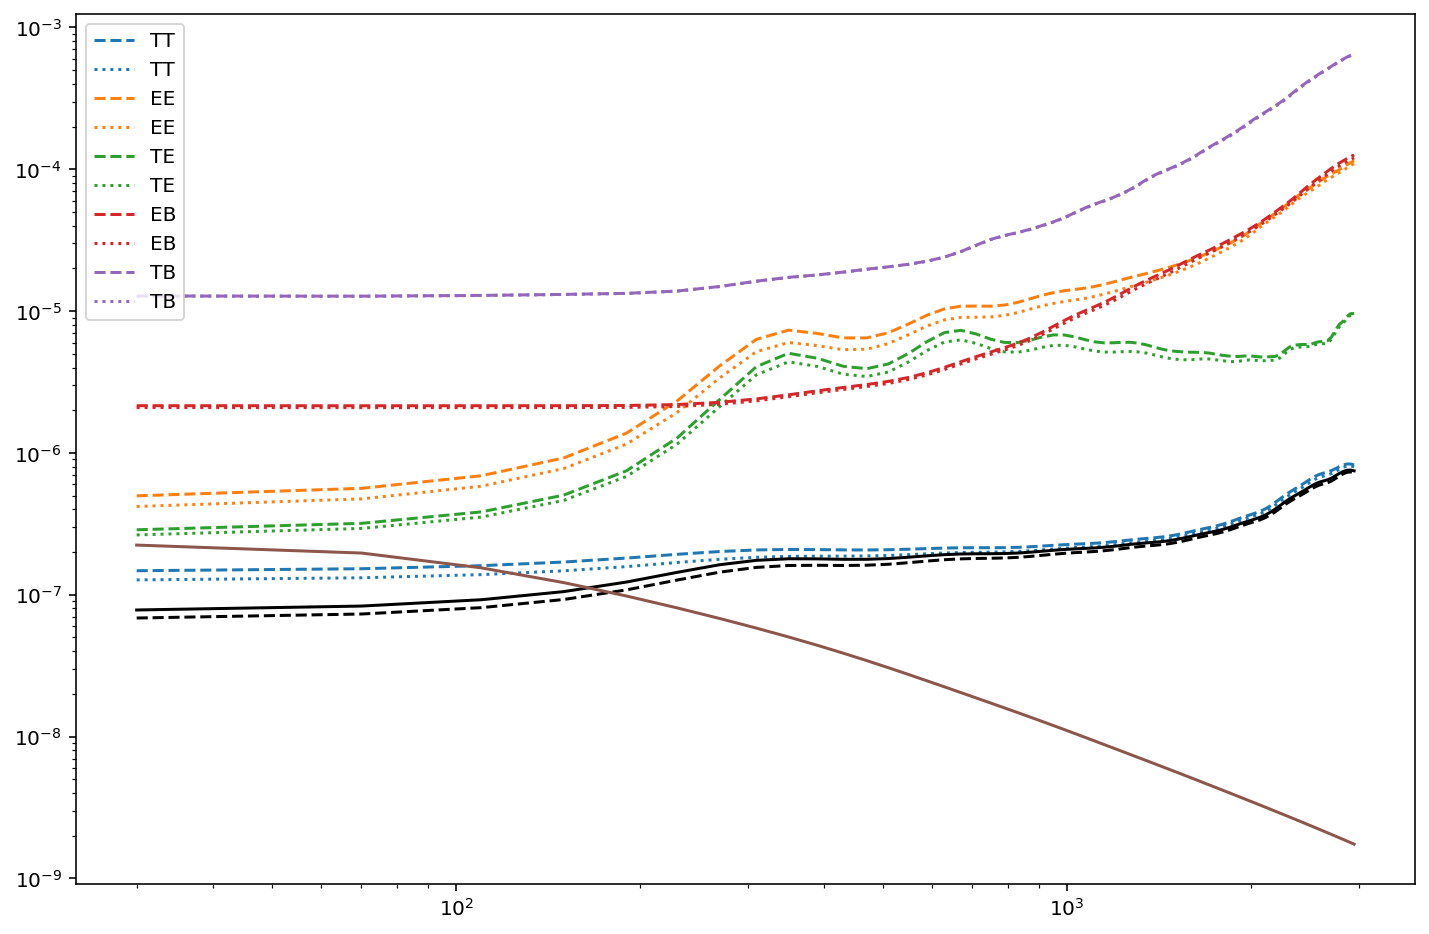

In [27]:
for XY in pols:
    cents, nl1d = binner.bin(noises[XY])
    p = plt.plot(cents, nl1d, ls = '--', label = XY)
    
    cents, nl1d = binner.bin(noises_[XY])
    plt.plot(cents, nl1d, ls = ':', label = XY, color = p[0].get_color())
    
cents, totl1d = binner.bin(tot)
plt.plot(cents, totl1d, color = 'black')

cents, totl1d_ = binner.bin(tot_)
plt.plot(cents, totl1d_, color = 'black', ls = '--')

clkk = theory.gCl('kk', cents)
plt.plot(cents, clkk)

plt.xscale('log')
plt.yscale('log')
plt.legend()

In [28]:
deltal = 40
fsky = 0.4

In [39]:
cents, nl1d = binner.bin(noises['TT'])
errorbar = 1/np.sqrt((cents*deltal*fsky))*(clkk+nl1d)
#errorbar = 1/np.sqrt((cents*deltal*fsky))*(clkk+totl1d)
np.sqrt(np.sum(((clkk/errorbar)**2.)[cents>10]))

67.79081823837393

In [40]:
cents, nl1d_ = binner.bin(noises_['TT'])
errorbar = 1/np.sqrt((cents*deltal*fsky))*(clkk+nl1d_)
#errorbar = 1/np.sqrt((cents*deltal*fsky))*(clkk+totl1d_)
np.sqrt(np.sum(((clkk/errorbar)**2.)[cents>10]))

73.16650285932585